# Segment nuclei and cells

In [12]:
import os
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.plot as plot

In [2]:
# hard-code the paths of our input and output directories
path_input = "../data/input"
path_output = "../data/output"

In this notebook, we show examples of nucleus and cell segmentation. We use 2D projections. Some postprocessing can be applied on the masks to refine the results with a priori informations and constraints.

**Nucleus segmentation** can be performed with two methods:
- A binarization of the dapi channel with a specific threshold.
- A prediction of a U-net-based convolutional neural network.

**Cell segmentation** can be performed with two methods:
- A watershed algorithm spread from the nucleus mask.
- A prediction of a U-net-based convolutional neural network.

In [3]:
recipe = {
    "fov": "fov_1",
    "c": ["dapi", "smfish"],
    "opt": "experience_1",
    "ext": "tif",
    "pattern": "opt_c_fov.ext"}
image = stack.build_stack(recipe, input_folder=path_input) 
print("\r shape: {0}".format(image.shape))
print("\r dtype: {0}".format(image.dtype))

 shape: (1, 2, 23, 650, 500)
 dtype: uint16


In [4]:
nuc = image[0, 0, ...]
print("dapi channel")
print("\r shape: {0}".format(nuc.shape))
print("\r dtype: {0}".format(nuc.dtype))
rna = image[0, 1, ...]
print("smfish channel")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))

dapi channel
 shape: (23, 650, 500)
 dtype: uint16
smfish channel
 shape: (23, 650, 500)
 dtype: uint16


## Nuclei segmentation

In [14]:
path = os.path.join(path_output, "nuc_mask.png")
nuc_mask = stack.read_image(path)
print(nuc_mask.shape, nuc_mask.dtype)

x_min = 700
x_max = 1200
y_min = 600
y_max = 1250
nuc_mask = nuc_mask[y_min:y_max, x_min: x_max]
#nuc_mask = nuc_mask.astype(bool)
print(nuc_mask.shape, nuc_mask.dtype)

(2048, 2048) uint8
(650, 500) uint8


In [40]:
path = os.path.join(path_output, "nuc_label.tif")
stack.save_image(nuc_mask.astype(np.uint8), path)

In [30]:
nuc_mask.min(), nuc_mask.max()

(0, 2)

## Cells segmentation

In [26]:
# cyt segmentation
rna_focus_2d = stack.maximum_projection(rna)
rna_mask_ = segmentation.build_cyt_binary_mask(rna_focus_2d, threshold=4800)
relief = segmentation.build_cyt_relief(rna_focus_2d, nuc_mask, rna_mask_, alpha=0.99)
cyt_mask = segmentation.cyt_watershed(relief, nuc_mask, rna_mask_, smooth=7)

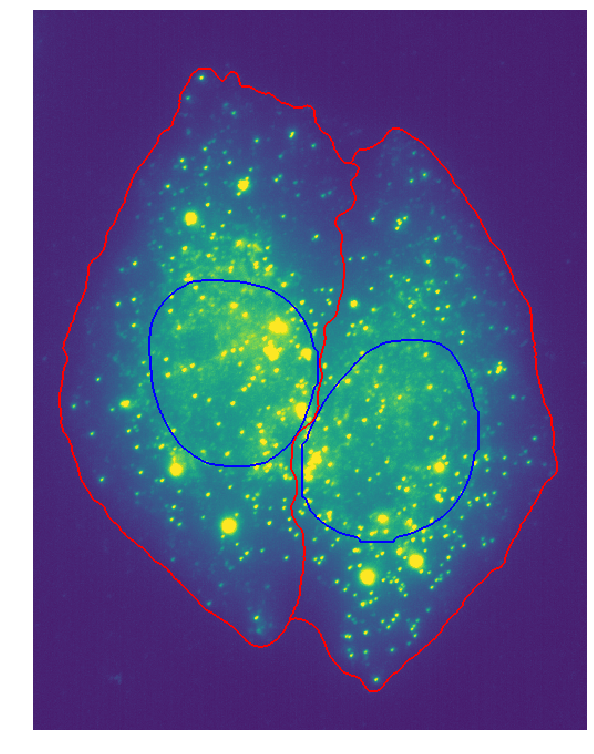

In [27]:
tensor = stack.rescale(rna, channel_to_stretch=0)
tensor = stack.maximum_projection(tensor)
plot.plot_segmentation_boundary(tensor, mask_nuc=nuc_mask, mask_cyt=cyt_mask,
                                rescale=False, title=None, framesize=(10, 10),
                                remove_frame=True, show=True)

In [43]:
path = os.path.join(path_output, "cell_label.tif")
stack.save_image(cyt_mask.astype(np.uint8), path)

In [32]:
import numpy as np

In [34]:
path

'../data/output/cell_mask.png'

In [42]:
os.listdir(path_output)

['.DS_Store',
 'nuc_mask.png',
 'spots.npy',
 '.gitignore',
 'cell_label.tif',
 'foci.csv',
 'nuc_label.tif',
 'spots.csv',
 'cell_mask.png',
 'foci.npy']